In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pandas numpy torch torch-geometric scikit-learn matplotlib optuna tensorflow keras-tuner scipy tqdm


In [ ]:
import pandas as pd
import numpy as np
import torch
import gc
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from scipy.spatial import cKDTree
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from tqdm import tqdm
from tensorflow.keras.models import load_model
import os

file_path = '/content/drive/MyDrive/THESIS/Train_model_ny_Vince.csv'
full_train_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Valid_model_ny_Vince.csv'
full_valid_data = pd.read_csv(file_path)


file_path = '/content/drive/MyDrive/THESIS/Test_model_ny_Vince.csv'
full_test_data = pd.read_csv(file_path)

In [ ]:
train_data = full_train_data.copy()
val_data = full_valid_data.copy()
test_data = full_test_data.copy()

# Preprocess function
def preprocess_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    return data

train_data = preprocess_data(train_data)
val_data = preprocess_data(val_data)
test_data = preprocess_data(test_data)

In this step, the data is preprocessed for the PE-GNN model. Since historical prices are no longer needed, only one data entry is kept for each unique Airbnb listing. The coordinates are then extracted to be used in the position encoder, and the other hedonic features are combined with the learned LSTM features to be added to the nodes of the GNN. Additionally, it is ensured that the spatial and temporal features, which are used for the baseline models, are removed from the data

In [ ]:
import pandas as pd

# Preprocess PE-GNN data and take the last instance for each id
def preprocess_pegnn_data(data):
    data['date'] = pd.to_datetime(data['date'])
    data = data.sort_values(['id', 'date'])
    data = data.drop_duplicates(subset=['id'], keep='last')
    return data

train_data_pegnn = preprocess_pegnn_data(train_data.copy())
val_data_pegnn = preprocess_pegnn_data(val_data.copy())
test_data_pegnn = preprocess_pegnn_data(test_data.copy())



In [ ]:

import pandas as pd

# Assume train_data_pegnn, val_data_pegnn, and test_data_pegnn are already loaded and contain the 'id' column

# Ensure IDs are consistent and merge the datasets
train_data_pegnn['id'] = train_data_pegnn['id'].astype(int)
val_data_pegnn['id'] = val_data_pegnn['id'].astype(int)
test_data_pegnn['id'] = test_data_pegnn['id'].astype(int)

train_features_with_ids_last['id'] = train_features_with_ids_last['id'].astype(int)
val_features_with_ids_last['id'] = val_features_with_ids_last['id'].astype(int)
test_features_with_ids_last['id'] = test_features_with_ids_last['id'].astype(int)

# Merge the LSTM features with the original data
train_data_pegnn = pd.merge(train_data_pegnn, train_features_with_ids_last, on='id', how='left')
val_data_pegnn = pd.merge(val_data_pegnn, val_features_with_ids_last, on='id', how='left')
test_data_pegnn = pd.merge(test_data_pegnn, test_features_with_ids_last, on='id', how='left')


In [ ]:
# Extract features
def extract_features(data):
    coordinates = data[['latitude', 'longitude']].to_numpy()
    # Dropping unnecessary columns including the specified features
    #features = data
    features = data.drop(columns=[
    'latitude', 'longitude', 'date', 'id', 'host_id', "nearby_restaurants_bars",
    "nearby_transport", "mean_price_neighbors", "neighbourhood_Astoria",
    "neighbourhood_Bedford-Stuyvesant", "neighbourhood_Chelsea",
    "neighbourhood_Clinton Hill", "neighbourhood_Crown Heights",
    "neighbourhood_East Flatbush", "neighbourhood_East Harlem",
    "neighbourhood_East Village", "neighbourhood_Financial District",
    "neighbourhood_Flatbush", "neighbourhood_Flushing",
    "neighbourhood_Fort Greene", "neighbourhood_Greenpoint",
    "neighbourhood_Harlem", "neighbourhood_Hell's Kitchen",
    "neighbourhood_Long Island City", "neighbourhood_Lower East Side",
    "neighbourhood_Midtown", "neighbourhood_Murray Hill",
    "neighbourhood_Upper East Side", "neighbourhood_Upper West Side",
    "neighbourhood_Washington Heights", "neighbourhood_West Village",
    "neighbourhood_Williamsburg", "neighbourhood_Woodside",
    "season_Autumn", "is_holiday", "is_school_holiday"
    ])





    for col in features.select_dtypes(include=['object']).columns:
        features[col] = features[col].astype('category').cat.codes
    features = features.apply(pd.to_numeric, errors='coerce').fillna(0)
    features = features.applymap(lambda x: 1 if x is True else 0 if x is False else x)
    non_numeric_cols = features.select_dtypes(exclude=[np.number]).columns.tolist()
    features = features.select_dtypes(include=[np.number])
    print("Dropped non-numeric features:", non_numeric_cols)

    features.columns = features.columns.astype(str)
    return coordinates, features



# Extracting features for train, validation, and test sets
train_coords_pegnn, train_features_pegnn = extract_features(train_data_pegnn)
val_coords_pegnn, val_features_pegnn = extract_features(val_data_pegnn)
test_coords_pegnn, test_features_pegnn = extract_features(test_data_pegnn)

train_prices_pegnn = train_features_pegnn['price'].values
val_prices_pegnn = val_features_pegnn['price'].values
test_prices_pegnn = test_features_pegnn['price'].values



# Scaling combined features
scaler = RobustScaler()
train_features_pegnn = pd.DataFrame(scaler.fit_transform(train_features_pegnn), columns=train_features_pegnn.columns)
val_features_pegnn = pd.DataFrame(scaler.transform(val_features_pegnn), columns=val_features_pegnn.columns)
test_features_pegnn = pd.DataFrame(scaler.transform(test_features_pegnn), columns=test_features_pegnn.columns)

# Initialize and fit the RobustScaler on the training prices
scaler = RobustScaler()
train_prices_pegnn_scaled = scaler.fit_transform(train_prices_pegnn.reshape(-1, 1))
val_prices_pegnn_scaled = scaler.transform(val_prices_pegnn.reshape(-1, 1))
test_prices_pegnn_scaled = scaler.transform(test_prices_pegnn.reshape(-1, 1))


# Convert the scaled prices to PyTorch tensors
y_train = torch.tensor(train_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_val = torch.tensor(val_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)
y_test = torch.tensor(test_prices_pegnn_scaled, dtype=torch.float).view(-1, 1)


# Extract and scale prices
#train_prices_pegnn = train_features_pegnn['price']
#val_prices_pegnn = val_features_pegnn['price']
#test_prices_pegnn = test_features_pegnn['price']


Dropped non-numeric features: []
Dropped non-numeric features: []
Dropped non-numeric features: []


In [ ]:
train_features_pegnn.head()

,available,price,host_response_time,host_is_superhost,host_listings_count,host_total_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,...,total_amenities,listing_reviewed,property_type_Apartment,property_type_Hotel,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Private room,luxury_amenities_score,kitchen_amenities
0,0.0,-0.442516,-0.333333,0.0,0.0,-0.25,0.0,-0.5,0.0,0.0,...,1.157895,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,0.333333
1,1.0,-0.373102,0.000000,0.0,5.0,2.50,0.0,0.0,0.0,0.0,...,-0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333
2,1.0,0.433839,-0.333333,0.0,0.0,0.25,-1.0,-0.5,0.0,0.0,...,-0.894737,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,2.0,-0.666667
3,0.0,-0.503254,-0.333333,0.0,0.0,-0.25,0.0,0.0,1.0,0.0,...,-0.631579,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,-0.666667
4,0.0,-0.095445,-0.333333,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,...,0.368421,0.0,-1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333


to save the dataset with lstm features

In [ ]:
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
train_data_pegnn.to_csv(path + 'train_data_lstm_london_FINAL.csv', index=False)
val_data_pegnn.to_csv(path + 'val_data_lstm_london_FINAL.csv', index=False)
test_data_pegnn.to_csv(path + 'test_data_lstm_london_FINAL.csv', index=False)

This section describes the creation of the PE-GNN model. It also includes the functionality to save the model and reuse it later. The edges of the GNN are created using a k-nearest neighbors approach, where edges are formed between the x number of closest neighbors in terms of physical distance. The number of nearest neighbors, along with several other variables, is hyperparameter-tuned using Optuna.

The position encoder learns by utilizing the coordinates of the nodes and adds this information to the nodes. As a result, the nodes contain information about the spatial aspect through the PE, the temporal aspect through the LSTM, and the hedonic features. This model also provides various performance metrics, which can be viewed below, along with several plots to track the evolution of these metrics throughout the learning process.

[I 2024-08-13 15:46:28,418] A new study created in memory with name: no-name-7bae813e-76df-4f76-a9e8-b5540038516e
Training PEGNN: 100%|██████████| 50/50 [01:33<00:00,  1.87s/it]
[I 2024-08-13 15:48:05,584] Trial 0 finished with value: 0.9417167901992798 and parameters: {'hidden_channels': 117, 'lr': 0.00015720420886092298, 'k': 92, 'dropout_rate': 0.38916285532739914}. Best is trial 0 with value: 0.9417167901992798.
Training PEGNN: 100%|██████████| 50/50 [00:57<00:00,  1.15s/it]
[I 2024-08-13 15:49:05,711] Trial 1 finished with value: 1.2261394262313843 and parameters: {'hidden_channels': 53, 'lr': 0.00011427358867870095, 'k': 69, 'dropout_rate': 0.20379974642625964}. Best is trial 0 with value: 0.9417167901992798.
Training PEGNN: 100%|██████████| 50/50 [02:14<00:00,  2.70s/it]
[I 2024-08-13 15:51:25,622] Trial 2 finished with value: 0.8323376178741455 and parameters: {'hidden_channels': 126, 'lr': 0.00028008824798924666, 'k': 130, 'dropout_rate': 0.4981104459956245}. Best is trial 2 w

Best parameters:  {'hidden_channels': 81, 'lr': 0.00638363602268586, 'k': 123, 'dropout_rate': 0.14020693010086607}


Final training:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.3652125597000122, Training R-squared: -0.060613236076759947, Training MAE: 0.6810926198959351, Training MSE: 1.3652124404907227


Final training:   0%|          | 1/500 [00:02<21:04,  2.53s/it]

Epoch 1, Validation Loss: 1.3581147193908691, Validation R-squared: -0.05075491661983689, Validation MAE: 0.8703991770744324, Validation MSE: 1.3581147193908691
Epoch 2, Training Loss: 1.3976885080337524, Training R-squared: -0.08584346027011458, Training MAE: 0.8862152695655823, Training MSE: 1.397688627243042


Final training:   0%|          | 2/500 [00:05<21:05,  2.54s/it]

Epoch 2, Validation Loss: 1.2005870342254639, Validation R-squared: 0.07112217827281164, Validation MAE: 0.6991661190986633, Validation MSE: 1.2005870342254639
Epoch 3, Training Loss: 1.1997414827346802, Training R-squared: 0.06793874038410141, Training MAE: 0.7031131386756897, Training MSE: 1.1997413635253906


Final training:   1%|          | 3/500 [00:07<21:07,  2.55s/it]

Epoch 3, Validation Loss: 1.2116533517837524, Validation R-squared: 0.06256035724727904, Validation MAE: 0.6633260846138, Validation MSE: 1.2116533517837524
Epoch 4, Training Loss: 1.203580379486084, Training R-squared: 0.06495634225417302, Training MAE: 0.6610679030418396, Training MSE: 1.203580379486084


Final training:   1%|          | 4/500 [00:10<21:07,  2.56s/it]

Epoch 4, Validation Loss: 1.187720775604248, Validation R-squared: 0.08107662468819088, Validation MAE: 0.6472198367118835, Validation MSE: 1.1877206563949585
Epoch 5, Training Loss: 1.1781901121139526, Training R-squared: 0.08468167355977363, Training MAE: 0.6437968015670776, Training MSE: 1.1781901121139526


Final training:   1%|          | 5/500 [00:12<21:37,  2.62s/it]

Epoch 5, Validation Loss: 1.1221944093704224, Validation R-squared: 0.13177344100766641, Validation MAE: 0.6329061388969421, Validation MSE: 1.1221944093704224
Epoch 6, Training Loss: 1.118343472480774, Training R-squared: 0.13117562779350367, Training MAE: 0.6307418346405029, Training MSE: 1.118343472480774


Final training:   1%|          | 6/500 [00:15<21:22,  2.60s/it]

Epoch 6, Validation Loss: 1.0387351512908936, Validation R-squared: 0.19634483687197257, Validation MAE: 0.6302398443222046, Validation MSE: 1.0387351512908936
Epoch 7, Training Loss: 1.0456552505493164, Training R-squared: 0.18764598552106204, Training MAE: 0.6302309036254883, Training MSE: 1.0456552505493164


Final training:   1%|▏         | 7/500 [00:18<21:17,  2.59s/it]

Epoch 7, Validation Loss: 0.9817686080932617, Validation R-squared: 0.24041906765327148, Validation MAE: 0.6441444158554077, Validation MSE: 0.9817685484886169
Epoch 8, Training Loss: 1.00763738155365, Training R-squared: 0.21718150845731055, Training MAE: 0.6513068675994873, Training MSE: 1.0076375007629395


Final training:   2%|▏         | 8/500 [00:20<21:06,  2.57s/it]

Epoch 8, Validation Loss: 0.9270753264427185, Validation R-squared: 0.2827343761236809, Validation MAE: 0.6201085448265076, Validation MSE: 0.9270754456520081
Epoch 9, Training Loss: 0.9466354846954346, Training R-squared: 0.264573014561135, Training MAE: 0.6211775541305542, Training MSE: 0.9466354250907898


Final training:   2%|▏         | 9/500 [00:23<20:58,  2.56s/it]

Epoch 9, Validation Loss: 0.8631237149238586, Validation R-squared: 0.33221284702989773, Validation MAE: 0.5524042248725891, Validation MSE: 0.8631237745285034
Epoch 10, Training Loss: 0.8801401257514954, Training R-squared: 0.31623223611685225, Training MAE: 0.5481950640678406, Training MSE: 0.8801401257514954


Final training:   2%|▏         | 10/500 [00:25<21:09,  2.59s/it]

Epoch 10, Validation Loss: 0.8433166146278381, Validation R-squared: 0.3475374683916028, Validation MAE: 0.5098080039024353, Validation MSE: 0.8433165550231934
Epoch 11, Training Loss: 0.8675158619880676, Training R-squared: 0.3260398863964621, Training MAE: 0.5075604319572449, Training MSE: 0.8675158023834229


Final training:   2%|▏         | 11/500 [00:28<20:59,  2.58s/it]

Epoch 11, Validation Loss: 0.8185025453567505, Validation R-squared: 0.36673575952518744, Validation MAE: 0.5097424983978271, Validation MSE: 0.8185025453567505
Epoch 12, Training Loss: 0.8547472357749939, Training R-squared: 0.3359595828991879, Training MAE: 0.5090588331222534, Training MSE: 0.8547472953796387


Final training:   2%|▏         | 12/500 [00:30<20:55,  2.57s/it]

Epoch 12, Validation Loss: 0.8041406273841858, Validation R-squared: 0.377847403574334, Validation MAE: 0.5354440808296204, Validation MSE: 0.8041405081748962
Epoch 13, Training Loss: 0.8394195437431335, Training R-squared: 0.34786750446784587, Training MAE: 0.5328723192214966, Training MSE: 0.839419424533844


Final training:   3%|▎         | 13/500 [00:33<20:47,  2.56s/it]

Epoch 13, Validation Loss: 0.7956573367118835, Validation R-squared: 0.38441071968821283, Validation MAE: 0.5374987721443176, Validation MSE: 0.7956573367118835
Epoch 14, Training Loss: 0.8230062127113342, Training R-squared: 0.36061872675767515, Training MAE: 0.5335029363632202, Training MSE: 0.8230062127113342


Final training:   3%|▎         | 14/500 [00:35<20:42,  2.56s/it]

Epoch 14, Validation Loss: 0.783447802066803, Validation R-squared: 0.3938571036408083, Validation MAE: 0.5101296305656433, Validation MSE: 0.783447802066803
Epoch 15, Training Loss: 0.800896406173706, Training R-squared: 0.37779548558426, Training MAE: 0.5025418996810913, Training MSE: 0.8008964657783508


Final training:   3%|▎         | 15/500 [00:38<20:54,  2.59s/it]

Epoch 15, Validation Loss: 0.7862218022346497, Validation R-squared: 0.39171092797740537, Validation MAE: 0.4983152151107788, Validation MSE: 0.7862218022346497
Epoch 16, Training Loss: 0.7968877553939819, Training R-squared: 0.3809097744968837, Training MAE: 0.48817121982574463, Training MSE: 0.7968877553939819


Final training:   3%|▎         | 16/500 [00:41<20:42,  2.57s/it]

Epoch 16, Validation Loss: 0.7703322768211365, Validation R-squared: 0.40400441374312646, Validation MAE: 0.5030482411384583, Validation MSE: 0.7703322768211365
Epoch 17, Training Loss: 0.7713388800621033, Training R-squared: 0.40075829707115684, Training MAE: 0.49276232719421387, Training MSE: 0.771338939666748


Final training:   3%|▎         | 17/500 [00:43<20:33,  2.55s/it]

Epoch 17, Validation Loss: 0.7582952380180359, Validation R-squared: 0.41331733269379234, Validation MAE: 0.5219404101371765, Validation MSE: 0.7582951784133911
Epoch 18, Training Loss: 0.7659664750099182, Training R-squared: 0.4049320160500689, Training MAE: 0.5119016766548157, Training MSE: 0.765966534614563


Final training:   4%|▎         | 18/500 [00:46<20:27,  2.55s/it]

Epoch 18, Validation Loss: 0.7517601847648621, Validation R-squared: 0.41837343604609434, Validation MAE: 0.5274472832679749, Validation MSE: 0.7517601251602173
Epoch 19, Training Loss: 0.75394207239151, Training R-squared: 0.41427369136854697, Training MAE: 0.5152566432952881, Training MSE: 0.7539419531822205


Final training:   4%|▍         | 19/500 [00:48<20:38,  2.58s/it]

Epoch 19, Validation Loss: 0.7436157464981079, Validation R-squared: 0.42467462218582663, Validation MAE: 0.5119718909263611, Validation MSE: 0.7436157464981079
Epoch 20, Training Loss: 0.7385214567184448, Training R-squared: 0.4262536523771052, Training MAE: 0.49688631296157837, Training MSE: 0.7385214567184448


Final training:   4%|▍         | 20/500 [00:51<20:45,  2.59s/it]

Epoch 20, Validation Loss: 0.7413213849067688, Validation R-squared: 0.4264497672419354, Validation MAE: 0.5024917721748352, Validation MSE: 0.741321325302124
Epoch 21, Training Loss: 0.730600893497467, Training R-squared: 0.4324069631373707, Training MAE: 0.48086491227149963, Training MSE: 0.7306010127067566


Final training:   4%|▍         | 21/500 [00:54<20:30,  2.57s/it]

Epoch 21, Validation Loss: 0.7321196794509888, Validation R-squared: 0.4335689761152063, Validation MAE: 0.501226007938385, Validation MSE: 0.7321196794509888
Epoch 22, Training Loss: 0.7241137623786926, Training R-squared: 0.4374467912143227, Training MAE: 0.48038703203201294, Training MSE: 0.7241137623786926


Final training:   4%|▍         | 22/500 [00:56<20:31,  2.58s/it]

Epoch 22, Validation Loss: 0.7190706133842468, Validation R-squared: 0.44366488423156325, Validation MAE: 0.5040868520736694, Validation MSE: 0.719070553779602
Epoch 23, Training Loss: 0.6985529661178589, Training R-squared: 0.45730460150018726, Training MAE: 0.48043569922447205, Training MSE: 0.6985529661178589


Final training:   5%|▍         | 23/500 [00:59<20:24,  2.57s/it]

Epoch 23, Validation Loss: 0.7083404660224915, Validation R-squared: 0.4519666307126926, Validation MAE: 0.50401771068573, Validation MSE: 0.7083404660224915
Epoch 24, Training Loss: 0.7013710141181946, Training R-squared: 0.45511533682502026, Training MAE: 0.48478129506111145, Training MSE: 0.7013709545135498


Final training:   5%|▍         | 24/500 [01:01<20:24,  2.57s/it]

Epoch 24, Validation Loss: 0.7018593549728394, Validation R-squared: 0.4569809594690897, Validation MAE: 0.4946448504924774, Validation MSE: 0.7018593549728394
Epoch 25, Training Loss: 0.6850702166557312, Training R-squared: 0.4677791663607691, Training MAE: 0.47330379486083984, Training MSE: 0.6850702166557312


Final training:   5%|▌         | 25/500 [01:04<20:28,  2.59s/it]

Epoch 25, Validation Loss: 0.7027512192726135, Validation R-squared: 0.4562909486498079, Validation MAE: 0.4870530366897583, Validation MSE: 0.7027512192726135
Epoch 26, Training Loss: 0.677748441696167, Training R-squared: 0.47346734098352206, Training MAE: 0.4604414105415344, Training MSE: 0.677748441696167


Final training:   5%|▌         | 26/500 [01:06<20:17,  2.57s/it]

Epoch 26, Validation Loss: 0.6988799571990967, Validation R-squared: 0.45928609346050275, Validation MAE: 0.48368164896965027, Validation MSE: 0.6988800168037415
Epoch 27, Training Loss: 0.6784725785255432, Training R-squared: 0.47290477332615666, Training MAE: 0.45980459451675415, Training MSE: 0.6784725785255432


Final training:   5%|▌         | 27/500 [01:09<20:12,  2.56s/it]

Epoch 27, Validation Loss: 0.6874648928642273, Validation R-squared: 0.4681177679160048, Validation MAE: 0.4853682816028595, Validation MSE: 0.6874648332595825
Epoch 28, Training Loss: 0.6703231334686279, Training R-squared: 0.4792359129208935, Training MAE: 0.4612624943256378, Training MSE: 0.6703231334686279


Final training:   6%|▌         | 28/500 [01:11<20:02,  2.55s/it]

Epoch 28, Validation Loss: 0.6802563071250916, Validation R-squared: 0.4736950335613235, Validation MAE: 0.4857426583766937, Validation MSE: 0.6802562475204468
Epoch 29, Training Loss: 0.6567612290382385, Training R-squared: 0.48977198739641736, Training MAE: 0.4639911651611328, Training MSE: 0.6567612290382385


Final training:   6%|▌         | 29/500 [01:14<20:05,  2.56s/it]

Epoch 29, Validation Loss: 0.6762517690658569, Validation R-squared: 0.4767932469622297, Validation MAE: 0.4797990918159485, Validation MSE: 0.6762517094612122
Epoch 30, Training Loss: 0.6489971280097961, Training R-squared: 0.4958037907078565, Training MAE: 0.4552672505378723, Training MSE: 0.6489971280097961


Final training:   6%|▌         | 30/500 [01:17<20:14,  2.58s/it]

Epoch 30, Validation Loss: 0.6741398572921753, Validation R-squared: 0.47842726327777996, Validation MAE: 0.4739369750022888, Validation MSE: 0.6741397976875305
Epoch 31, Training Loss: 0.6468245387077332, Training R-squared: 0.4974916079689138, Training MAE: 0.4462331235408783, Training MSE: 0.6468245983123779


Final training:   6%|▌         | 31/500 [01:19<20:11,  2.58s/it]

Epoch 31, Validation Loss: 0.6631778478622437, Validation R-squared: 0.4869083516875897, Validation MAE: 0.4738650918006897, Validation MSE: 0.6631778478622437
Epoch 32, Training Loss: 0.6469120979309082, Training R-squared: 0.49742366385809367, Training MAE: 0.4502864480018616, Training MSE: 0.6469120979309082


Final training:   6%|▋         | 32/500 [01:22<20:03,  2.57s/it]

Epoch 32, Validation Loss: 0.6574771404266357, Validation R-squared: 0.49131889308077703, Validation MAE: 0.47382670640945435, Validation MSE: 0.6574772000312805
Epoch 33, Training Loss: 0.6266927123069763, Training R-squared: 0.5131317837046696, Training MAE: 0.44685545563697815, Training MSE: 0.6266927719116211


Final training:   7%|▋         | 33/500 [01:24<19:54,  2.56s/it]

Epoch 33, Validation Loss: 0.6560488343238831, Validation R-squared: 0.4924239331734729, Validation MAE: 0.4696139991283417, Validation MSE: 0.6560488939285278
Epoch 34, Training Loss: 0.6237451434135437, Training R-squared: 0.5154216934850961, Training MAE: 0.4429081976413727, Training MSE: 0.6237452030181885


Final training:   7%|▋         | 34/500 [01:27<19:55,  2.57s/it]

Epoch 34, Validation Loss: 0.6569794416427612, Validation R-squared: 0.4917039583670032, Validation MAE: 0.466268926858902, Validation MSE: 0.6569794416427612
Epoch 35, Training Loss: 0.631524920463562, Training R-squared: 0.5093777085015083, Training MAE: 0.4418509900569916, Training MSE: 0.631524920463562


Final training:   7%|▋         | 35/500 [01:30<20:00,  2.58s/it]

Epoch 35, Validation Loss: 0.6570574045181274, Validation R-squared: 0.4916436268110912, Validation MAE: 0.46692657470703125, Validation MSE: 0.6570573449134827
Epoch 36, Training Loss: 0.6345237493515015, Training R-squared: 0.507047962278386, Training MAE: 0.4449304938316345, Training MSE: 0.6345237493515015


Final training:   7%|▋         | 36/500 [01:32<19:49,  2.56s/it]

Epoch 36, Validation Loss: 0.6502861380577087, Validation R-squared: 0.4968825138244133, Validation MAE: 0.4751589894294739, Validation MSE: 0.650286078453064
Epoch 37, Training Loss: 0.6186484694480896, Training R-squared: 0.5193811728642592, Training MAE: 0.4499746859073639, Training MSE: 0.6186485290527344


Final training:   7%|▋         | 37/500 [01:35<19:40,  2.55s/it]

Epoch 37, Validation Loss: 0.6510055065155029, Validation R-squared: 0.49632594874163716, Validation MAE: 0.4739164710044861, Validation MSE: 0.6510055065155029
Epoch 38, Training Loss: 0.6048922538757324, Training R-squared: 0.5300682117348524, Training MAE: 0.4442705810070038, Training MSE: 0.6048923134803772


Final training:   8%|▊         | 38/500 [01:37<19:36,  2.55s/it]

Epoch 38, Validation Loss: 0.6544269919395447, Validation R-squared: 0.49367868224352907, Validation MAE: 0.4683074653148651, Validation MSE: 0.6544271111488342
Epoch 39, Training Loss: 0.6034486889839172, Training R-squared: 0.5311897132555321, Training MAE: 0.43727564811706543, Training MSE: 0.6034486293792725


Final training:   8%|▊         | 39/500 [01:40<19:46,  2.57s/it]

Epoch 39, Validation Loss: 0.6511952877044678, Validation R-squared: 0.49617906621746477, Validation MAE: 0.46608343720436096, Validation MSE: 0.6511952877044678
Epoch 40, Training Loss: 0.6004112958908081, Training R-squared: 0.5335494165909449, Training MAE: 0.4343417286872864, Training MSE: 0.6004112958908081


Final training:   8%|▊         | 40/500 [01:42<19:51,  2.59s/it]

Epoch 40, Validation Loss: 0.6411020755767822, Validation R-squared: 0.5039880478024491, Validation MAE: 0.4687073528766632, Validation MSE: 0.6411020755767822
Epoch 41, Training Loss: 0.6005439162254333, Training R-squared: 0.533446359526411, Training MAE: 0.44246727228164673, Training MSE: 0.6005439162254333


Final training:   8%|▊         | 41/500 [01:45<19:38,  2.57s/it]

Epoch 41, Validation Loss: 0.6425279378890991, Validation R-squared: 0.5028848966108965, Validation MAE: 0.463406503200531, Validation MSE: 0.6425279378890991
Epoch 42, Training Loss: 0.5856482982635498, Training R-squared: 0.545018559226395, Training MAE: 0.42948848009109497, Training MSE: 0.5856482982635498


Final training:   8%|▊         | 42/500 [01:47<19:32,  2.56s/it]

Epoch 42, Validation Loss: 0.6462103128433228, Validation R-squared: 0.5000358838116181, Validation MAE: 0.4589579403400421, Validation MSE: 0.6462103128433228
Epoch 43, Training Loss: 0.5912629961967468, Training R-squared: 0.5406566132547673, Training MAE: 0.42923349142074585, Training MSE: 0.5912629961967468


Final training:   9%|▊         | 43/500 [01:50<19:43,  2.59s/it]

Epoch 43, Validation Loss: 0.6397635340690613, Validation R-squared: 0.5050236652276106, Validation MAE: 0.46006226539611816, Validation MSE: 0.6397635340690613
Epoch 44, Training Loss: 0.5766116976737976, Training R-squared: 0.5520389619709912, Training MAE: 0.4283618628978729, Training MSE: 0.5766116380691528


Final training:   9%|▉         | 44/500 [01:53<19:45,  2.60s/it]

Epoch 44, Validation Loss: 0.6341912150382996, Validation R-squared: 0.5093348680672471, Validation MAE: 0.46376311779022217, Validation MSE: 0.6341912746429443
Epoch 45, Training Loss: 0.5752046704292297, Training R-squared: 0.5531320783379523, Training MAE: 0.43240731954574585, Training MSE: 0.5752046704292297


Final training:   9%|▉         | 45/500 [01:55<19:45,  2.61s/it]

Epoch 45, Validation Loss: 0.6351911425590515, Validation R-squared: 0.5085612554577279, Validation MAE: 0.46054619550704956, Validation MSE: 0.6351911425590515
Epoch 46, Training Loss: 0.5788813829421997, Training R-squared: 0.550275645404138, Training MAE: 0.4306093454360962, Training MSE: 0.5788814425468445


Final training:   9%|▉         | 46/500 [01:58<19:27,  2.57s/it]

Epoch 46, Validation Loss: 0.636407732963562, Validation R-squared: 0.5076200108404578, Validation MAE: 0.45846793055534363, Validation MSE: 0.636407732963562
Epoch 47, Training Loss: 0.5769011378288269, Training R-squared: 0.5518140980194526, Training MAE: 0.42501986026763916, Training MSE: 0.5769011378288269


Final training:   9%|▉         | 47/500 [02:00<19:18,  2.56s/it]

Epoch 47, Validation Loss: 0.630413293838501, Validation R-squared: 0.5122578432517743, Validation MAE: 0.4600992500782013, Validation MSE: 0.630413293838501
Epoch 48, Training Loss: 0.5696272253990173, Training R-squared: 0.5574651245014896, Training MAE: 0.42808911204338074, Training MSE: 0.5696272253990173


Final training:  10%|▉         | 48/500 [02:03<19:14,  2.55s/it]

Epoch 48, Validation Loss: 0.6229608058929443, Validation R-squared: 0.5180237004622537, Validation MAE: 0.462434321641922, Validation MSE: 0.6229608058929443
Epoch 49, Training Loss: 0.5596392750740051, Training R-squared: 0.5652245764538019, Training MAE: 0.4296417534351349, Training MSE: 0.5596393346786499


Final training:  10%|▉         | 49/500 [02:06<19:22,  2.58s/it]

Epoch 49, Validation Loss: 0.6211413145065308, Validation R-squared: 0.5194314185051996, Validation MAE: 0.45659688115119934, Validation MSE: 0.6211413145065308
Epoch 50, Training Loss: 0.5516251921653748, Training R-squared: 0.5714506039409607, Training MAE: 0.4207572937011719, Training MSE: 0.5516251921653748


Final training:  10%|█         | 50/500 [02:08<19:18,  2.58s/it]

Epoch 50, Validation Loss: 0.6251121163368225, Validation R-squared: 0.5163592540242169, Validation MAE: 0.4515601694583893, Validation MSE: 0.6251121163368225
Epoch 51, Training Loss: 0.5492401123046875, Training R-squared: 0.5733035450627264, Training MAE: 0.4145309329032898, Training MSE: 0.5492400527000427


Final training:  10%|█         | 51/500 [02:11<19:12,  2.57s/it]

Epoch 51, Validation Loss: 0.6163203120231628, Validation R-squared: 0.5231613475587882, Validation MAE: 0.45401912927627563, Validation MSE: 0.6163203120231628
Epoch 52, Training Loss: 0.547446072101593, Training R-squared: 0.5746973263466059, Training MAE: 0.42182397842407227, Training MSE: 0.547446072101593


Final training:  10%|█         | 52/500 [02:13<19:13,  2.57s/it]

Epoch 52, Validation Loss: 0.6134362816810608, Validation R-squared: 0.5253926683970034, Validation MAE: 0.45612457394599915, Validation MSE: 0.6134362816810608
Epoch 53, Training Loss: 0.5466998815536499, Training R-squared: 0.5752770287446347, Training MAE: 0.42373770475387573, Training MSE: 0.5466998815536499


Final training:  11%|█         | 53/500 [02:16<19:08,  2.57s/it]

Epoch 53, Validation Loss: 0.6191330552101135, Validation R-squared: 0.5209852392358467, Validation MAE: 0.4522935152053833, Validation MSE: 0.619132936000824
Epoch 54, Training Loss: 0.5401478409767151, Training R-squared: 0.580367169408276, Training MAE: 0.4170299470424652, Training MSE: 0.5401478409767151


Final training:  11%|█         | 54/500 [02:18<19:14,  2.59s/it]

Epoch 54, Validation Loss: 0.6168457269668579, Validation R-squared: 0.5227548862163913, Validation MAE: 0.4518468677997589, Validation MSE: 0.6168457269668579
Epoch 55, Training Loss: 0.5323678851127625, Training R-squared: 0.5864113104082005, Training MAE: 0.4142773449420929, Training MSE: 0.5323679447174072


Final training:  11%|█         | 55/500 [02:21<19:15,  2.60s/it]

Epoch 55, Validation Loss: 0.608911395072937, Validation R-squared: 0.5288935938608064, Validation MAE: 0.45383670926094055, Validation MSE: 0.608911395072937
Epoch 56, Training Loss: 0.5245395302772522, Training R-squared: 0.5924931091212737, Training MAE: 0.4151146113872528, Training MSE: 0.5245394706726074


Final training:  11%|█         | 56/500 [02:24<18:59,  2.57s/it]

Epoch 56, Validation Loss: 0.6103753447532654, Validation R-squared: 0.5277609068400673, Validation MAE: 0.45016002655029297, Validation MSE: 0.6103753447532654
Epoch 57, Training Loss: 0.523095965385437, Training R-squared: 0.5936145622823559, Training MAE: 0.4139774441719055, Training MSE: 0.523095965385437


Final training:  11%|█▏        | 57/500 [02:26<18:54,  2.56s/it]

Epoch 57, Validation Loss: 0.6127638220787048, Validation R-squared: 0.525913006207579, Validation MAE: 0.4471743702888489, Validation MSE: 0.6127638220787048
Epoch 58, Training Loss: 0.5148140788078308, Training R-squared: 0.6000485960837734, Training MAE: 0.40668660402297974, Training MSE: 0.5148141384124756


Final training:  12%|█▏        | 58/500 [02:29<18:49,  2.56s/it]

Epoch 58, Validation Loss: 0.6083360910415649, Validation R-squared: 0.5293386406263669, Validation MAE: 0.44764256477355957, Validation MSE: 0.6083360910415649
Epoch 59, Training Loss: 0.5111680030822754, Training R-squared: 0.6028812042646698, Training MAE: 0.4061032831668854, Training MSE: 0.5111679434776306


Final training:  12%|█▏        | 59/500 [02:31<18:56,  2.58s/it]

Epoch 59, Validation Loss: 0.5991153717041016, Validation R-squared: 0.5364725944768404, Validation MAE: 0.45273688435554504, Validation MSE: 0.5991153717041016
Epoch 60, Training Loss: 0.5165395140647888, Training R-squared: 0.5987081528971523, Training MAE: 0.421027272939682, Training MSE: 0.5165395140647888


Final training:  12%|█▏        | 60/500 [02:34<18:50,  2.57s/it]

Epoch 60, Validation Loss: 0.6035045385360718, Validation R-squared: 0.5330767516216013, Validation MAE: 0.44697290658950806, Validation MSE: 0.6035045385360718
Epoch 61, Training Loss: 0.5029181241989136, Training R-squared: 0.6092904244985058, Training MAE: 0.40729227662086487, Training MSE: 0.5029180645942688


Final training:  12%|█▏        | 61/500 [02:36<18:52,  2.58s/it]

Epoch 61, Validation Loss: 0.6103124618530273, Validation R-squared: 0.5278095989358483, Validation MAE: 0.44450971484184265, Validation MSE: 0.6103124022483826
Epoch 62, Training Loss: 0.510377824306488, Training R-squared: 0.6034950720417401, Training MAE: 0.4056587219238281, Training MSE: 0.510377824306488


Final training:  12%|█▏        | 62/500 [02:39<18:45,  2.57s/it]

Epoch 62, Validation Loss: 0.5936928391456604, Validation R-squared: 0.5406679852080892, Validation MAE: 0.45100292563438416, Validation MSE: 0.5936927199363708
Epoch 63, Training Loss: 0.4971199631690979, Training R-squared: 0.6137949129630853, Training MAE: 0.41287368535995483, Training MSE: 0.4971199929714203


Final training:  13%|█▎        | 63/500 [02:41<18:36,  2.56s/it]

Epoch 63, Validation Loss: 0.597395122051239, Validation R-squared: 0.5378035096253859, Validation MAE: 0.4476752281188965, Validation MSE: 0.597395122051239
Epoch 64, Training Loss: 0.4883439838886261, Training R-squared: 0.6206128017538541, Training MAE: 0.4071018397808075, Training MSE: 0.4883440434932709


Final training:  13%|█▎        | 64/500 [02:44<18:46,  2.58s/it]

Epoch 64, Validation Loss: 0.615699052810669, Validation R-squared: 0.5236420783794483, Validation MAE: 0.44377321004867554, Validation MSE: 0.6156989932060242
Epoch 65, Training Loss: 0.4990379512310028, Training R-squared: 0.612304870485044, Training MAE: 0.399086594581604, Training MSE: 0.4990379214286804


Final training:  13%|█▎        | 65/500 [02:47<18:44,  2.59s/it]

Epoch 65, Validation Loss: 0.5949565172195435, Validation R-squared: 0.5396902507358747, Validation MAE: 0.44987013936042786, Validation MSE: 0.5949565172195435
Epoch 66, Training Loss: 0.4938106834888458, Training R-squared: 0.6163658161166927, Training MAE: 0.41064587235450745, Training MSE: 0.4938107132911682


Final training:  13%|█▎        | 66/500 [02:49<18:31,  2.56s/it]

Epoch 66, Validation Loss: 0.5938799381256104, Validation R-squared: 0.5405231896277636, Validation MAE: 0.44871875643730164, Validation MSE: 0.5938799381256104
Epoch 67, Training Loss: 0.47743216156959534, Training R-squared: 0.6290900642610526, Training MAE: 0.4070080518722534, Training MSE: 0.4774322211742401


Final training:  13%|█▎        | 67/500 [02:52<18:22,  2.55s/it]

Epoch 67, Validation Loss: 0.608296275138855, Validation R-squared: 0.529369454481884, Validation MAE: 0.4408263564109802, Validation MSE: 0.608296275138855
Epoch 68, Training Loss: 0.4869246780872345, Training R-squared: 0.6217154722344537, Training MAE: 0.39429834485054016, Training MSE: 0.4869247376918793


Final training:  14%|█▎        | 68/500 [02:54<18:18,  2.54s/it]

Epoch 68, Validation Loss: 0.5931912660598755, Validation R-squared: 0.5410559834057219, Validation MAE: 0.4426892101764679, Validation MSE: 0.5931912660598755
Epoch 69, Training Loss: 0.47578898072242737, Training R-squared: 0.6303666261627701, Training MAE: 0.3976704180240631, Training MSE: 0.47578898072242737


Final training:  14%|█▍        | 69/500 [02:57<18:35,  2.59s/it]

Epoch 69, Validation Loss: 0.5887521505355835, Validation R-squared: 0.5444904628309153, Validation MAE: 0.44878748059272766, Validation MSE: 0.5887522101402283
Epoch 70, Training Loss: 0.4713193476200104, Training R-squared: 0.6338390323602638, Training MAE: 0.40557315945625305, Training MSE: 0.4713193476200104


Final training:  14%|█▍        | 70/500 [03:00<18:26,  2.57s/it]

Epoch 70, Validation Loss: 0.596041738986969, Validation R-squared: 0.5388506070817027, Validation MAE: 0.43884241580963135, Validation MSE: 0.596041738986969
Epoch 71, Training Loss: 0.4749758243560791, Training R-squared: 0.6309983455824003, Training MAE: 0.3913629651069641, Training MSE: 0.4749758243560791


Final training:  14%|█▍        | 71/500 [03:02<18:16,  2.56s/it]

Epoch 71, Validation Loss: 0.5964483618736267, Validation R-squared: 0.5385359953032165, Validation MAE: 0.4388808310031891, Validation MSE: 0.5964483618736267
Epoch 72, Training Loss: 0.4635933041572571, Training R-squared: 0.639841268542703, Training MAE: 0.39033055305480957, Training MSE: 0.4635933041572571


Final training:  14%|█▍        | 72/500 [03:05<18:11,  2.55s/it]

Epoch 72, Validation Loss: 0.5831409692764282, Validation R-squared: 0.5488317543772976, Validation MAE: 0.4491503834724426, Validation MSE: 0.5831409692764282
Epoch 73, Training Loss: 0.4546700119972229, Training R-squared: 0.6467736163567743, Training MAE: 0.4014323055744171, Training MSE: 0.4546700716018677


Final training:  15%|█▍        | 73/500 [03:07<18:15,  2.57s/it]

Epoch 73, Validation Loss: 0.5893332362174988, Validation R-squared: 0.5440408929202565, Validation MAE: 0.44196081161499023, Validation MSE: 0.5893332362174988
Epoch 74, Training Loss: 0.4512055516242981, Training R-squared: 0.6494651005756802, Training MAE: 0.39130985736846924, Training MSE: 0.4512055516242981


Final training:  15%|█▍        | 74/500 [03:10<18:39,  2.63s/it]

Epoch 74, Validation Loss: 0.593095064163208, Validation R-squared: 0.5411303942006203, Validation MAE: 0.43883153796195984, Validation MSE: 0.593095064163208
Epoch 75, Training Loss: 0.4532124102115631, Training R-squared: 0.6479060444074323, Training MAE: 0.38866886496543884, Training MSE: 0.4532124102115631


Final training:  15%|█▌        | 75/500 [03:13<18:31,  2.62s/it]

Epoch 75, Validation Loss: 0.5812628865242004, Validation R-squared: 0.550284831175768, Validation MAE: 0.44359320402145386, Validation MSE: 0.5812628865242004
Epoch 76, Training Loss: 0.44464054703712463, Training R-squared: 0.6545654152829952, Training MAE: 0.39221805334091187, Training MSE: 0.44464054703712463


Final training:  15%|█▌        | 76/500 [03:15<18:15,  2.58s/it]

Epoch 76, Validation Loss: 0.582229495048523, Validation R-squared: 0.5495369879345751, Validation MAE: 0.44015052914619446, Validation MSE: 0.582229495048523
Epoch 77, Training Loss: 0.4370577931404114, Training R-squared: 0.6604563235792233, Training MAE: 0.38885027170181274, Training MSE: 0.4370577931404114


Final training:  15%|█▌        | 77/500 [03:18<18:03,  2.56s/it]

Epoch 77, Validation Loss: 0.5930876731872559, Validation R-squared: 0.5411361850086993, Validation MAE: 0.4350758194923401, Validation MSE: 0.5930876135826111
Epoch 78, Training Loss: 0.45136380195617676, Training R-squared: 0.6493421674791183, Training MAE: 0.3851414918899536, Training MSE: 0.45136386156082153


Final training:  16%|█▌        | 78/500 [03:20<18:04,  2.57s/it]

Epoch 78, Validation Loss: 0.5841039419174194, Validation R-squared: 0.5480867308961024, Validation MAE: 0.44037488102912903, Validation MSE: 0.5841039419174194
Epoch 79, Training Loss: 0.4367486238479614, Training R-squared: 0.6606965189885488, Training MAE: 0.38396355509757996, Training MSE: 0.4367486238479614


Final training:  16%|█▌        | 79/500 [03:23<18:20,  2.61s/it]

Epoch 79, Validation Loss: 0.5785402059555054, Validation R-squared: 0.5523913054386526, Validation MAE: 0.4476768970489502, Validation MSE: 0.5785402059555054
Epoch 80, Training Loss: 0.4297851622104645, Training R-squared: 0.6661063231487259, Training MAE: 0.39193326234817505, Training MSE: 0.4297851622104645


Final training:  16%|█▌        | 80/500 [03:25<18:08,  2.59s/it]

Epoch 80, Validation Loss: 0.5993887782096863, Validation R-squared: 0.5362610877837128, Validation MAE: 0.43744367361068726, Validation MSE: 0.5993887186050415
Epoch 81, Training Loss: 0.4306974411010742, Training R-squared: 0.6653975863195912, Training MAE: 0.3804653286933899, Training MSE: 0.4306974411010742


Final training:  16%|█▌        | 81/500 [03:28<17:56,  2.57s/it]

Epoch 81, Validation Loss: 0.5882818698883057, Validation R-squared: 0.5448543300313445, Validation MAE: 0.4378648102283478, Validation MSE: 0.5882818698883057
Epoch 82, Training Loss: 0.4366743564605713, Training R-squared: 0.660754177534232, Training MAE: 0.3792608380317688, Training MSE: 0.4366743862628937


Final training:  16%|█▋        | 82/500 [03:30<17:47,  2.55s/it]

Epoch 82, Validation Loss: 0.5787026286125183, Validation R-squared: 0.5522656728653927, Validation MAE: 0.44764384627342224, Validation MSE: 0.5787026286125183
Epoch 83, Training Loss: 0.4319652020931244, Training R-squared: 0.6644126489320406, Training MAE: 0.3946288228034973, Training MSE: 0.4319652020931244


Final training:  17%|█▋        | 83/500 [03:33<17:48,  2.56s/it]

Epoch 83, Validation Loss: 0.5893256068229675, Validation R-squared: 0.5440467764879264, Validation MAE: 0.43528372049331665, Validation MSE: 0.5893256664276123
Epoch 84, Training Loss: 0.4304560422897339, Training R-squared: 0.6655850957393866, Training MAE: 0.3793213665485382, Training MSE: 0.4304560422897339


Final training:  17%|█▋        | 84/500 [03:36<17:57,  2.59s/it]

Epoch 84, Validation Loss: 0.5901867747306824, Validation R-squared: 0.5433805182034065, Validation MAE: 0.4347717761993408, Validation MSE: 0.5901867747306824
Epoch 85, Training Loss: 0.4224567115306854, Training R-squared: 0.6717996658743413, Training MAE: 0.37571850419044495, Training MSE: 0.4224567413330078


Final training:  17%|█▋        | 85/500 [03:38<17:51,  2.58s/it]

Epoch 85, Validation Loss: 0.5733722448348999, Validation R-squared: 0.5563896837009825, Validation MAE: 0.44577687978744507, Validation MSE: 0.5733722448348999
Epoch 86, Training Loss: 0.43153926730155945, Training R-squared: 0.6647436039012706, Training MAE: 0.3912143111228943, Training MSE: 0.43153923749923706


Final training:  17%|█▋        | 86/500 [03:41<17:46,  2.58s/it]

Epoch 86, Validation Loss: 0.5799407362937927, Validation R-squared: 0.5513077372506145, Validation MAE: 0.4378877580165863, Validation MSE: 0.5799407362937927
Epoch 87, Training Loss: 0.4079134464263916, Training R-squared: 0.68309813578029, Training MAE: 0.37684428691864014, Training MSE: 0.4079134464263916


Final training:  17%|█▋        | 87/500 [03:43<17:36,  2.56s/it]

Epoch 87, Validation Loss: 0.5904300808906555, Validation R-squared: 0.5431923148612292, Validation MAE: 0.434719443321228, Validation MSE: 0.5904300808906555
Epoch 88, Training Loss: 0.413816899061203, Training R-squared: 0.6785118185258403, Training MAE: 0.3731526732444763, Training MSE: 0.413816899061203


Final training:  18%|█▊        | 88/500 [03:46<17:34,  2.56s/it]

Epoch 88, Validation Loss: 0.571161150932312, Validation R-squared: 0.5581004278165609, Validation MAE: 0.44495493173599243, Validation MSE: 0.571161150932312
Epoch 89, Training Loss: 0.4109400510787964, Training R-squared: 0.6807467816872569, Training MAE: 0.3865921199321747, Training MSE: 0.4109400510787964


Final training:  18%|█▊        | 89/500 [03:48<17:40,  2.58s/it]

Epoch 89, Validation Loss: 0.5715703368186951, Validation R-squared: 0.5577838265396498, Validation MAE: 0.4362746477127075, Validation MSE: 0.5715703368186951
Epoch 90, Training Loss: 0.40779808163642883, Training R-squared: 0.683187717881071, Training MAE: 0.3776789605617523, Training MSE: 0.4077981412410736


Final training:  18%|█▊        | 90/500 [03:51<17:34,  2.57s/it]

Epoch 90, Validation Loss: 0.5953895449638367, Validation R-squared: 0.5393552374571975, Validation MAE: 0.4322645366191864, Validation MSE: 0.5953895449638367
Epoch 91, Training Loss: 0.4139673709869385, Training R-squared: 0.6783949304439572, Training MAE: 0.36903923749923706, Training MSE: 0.4139673709869385


Final training:  18%|█▊        | 91/500 [03:54<17:28,  2.56s/it]

Epoch 91, Validation Loss: 0.5697154402732849, Validation R-squared: 0.5592189050564694, Validation MAE: 0.44247522950172424, Validation MSE: 0.5697154402732849
Epoch 92, Training Loss: 0.40734073519706726, Training R-squared: 0.6835430354694287, Training MAE: 0.38388410210609436, Training MSE: 0.40734073519706726


Final training:  18%|█▊        | 92/500 [03:56<17:20,  2.55s/it]

Epoch 92, Validation Loss: 0.5684515237808228, Validation R-squared: 0.560196813368882, Validation MAE: 0.44681766629219055, Validation MSE: 0.5684515237808228
Epoch 93, Training Loss: 0.40199294686317444, Training R-squared: 0.6876977009368961, Training MAE: 0.38225117325782776, Training MSE: 0.40199291706085205


Final training:  19%|█▊        | 93/500 [03:59<17:20,  2.56s/it]

Epoch 93, Validation Loss: 0.5955635905265808, Validation R-squared: 0.5392205322598396, Validation MAE: 0.43404650688171387, Validation MSE: 0.5955636501312256
Epoch 94, Training Loss: 0.40872061252593994, Training R-squared: 0.682471026666621, Training MAE: 0.37057462334632874, Training MSE: 0.4087206721305847


Final training:  19%|█▉        | 94/500 [04:01<17:27,  2.58s/it]

Epoch 94, Validation Loss: 0.5826963782310486, Validation R-squared: 0.5491758018226933, Validation MAE: 0.4348185360431671, Validation MSE: 0.5826963186264038
Epoch 95, Training Loss: 0.40028414130210876, Training R-squared: 0.6890252187325958, Training MAE: 0.36803966760635376, Training MSE: 0.40028417110443115


Final training:  19%|█▉        | 95/500 [04:04<17:15,  2.56s/it]

Epoch 95, Validation Loss: 0.5727161765098572, Validation R-squared: 0.5568972914282729, Validation MAE: 0.4528404176235199, Validation MSE: 0.5727161765098572
Epoch 96, Training Loss: 0.42611825466156006, Training R-squared: 0.668955096026461, Training MAE: 0.3951038420200348, Training MSE: 0.42611825466156006


Final training:  19%|█▉        | 96/500 [04:06<17:12,  2.56s/it]

Epoch 96, Validation Loss: 0.596413254737854, Validation R-squared: 0.5385631430337233, Validation MAE: 0.43477123975753784, Validation MSE: 0.5964133143424988
Epoch 97, Training Loss: 0.3946594297885895, Training R-squared: 0.6933949733562212, Training MAE: 0.36384278535842896, Training MSE: 0.3946594297885895


Final training:  19%|█▉        | 97/500 [04:09<17:03,  2.54s/it]

Epoch 97, Validation Loss: 0.5898699760437012, Validation R-squared: 0.5436256120597779, Validation MAE: 0.43395134806632996, Validation MSE: 0.589870035648346
Epoch 98, Training Loss: 0.40399861335754395, Training R-squared: 0.6861395070753702, Training MAE: 0.3660109341144562, Training MSE: 0.40399861335754395


Final training:  20%|█▉        | 98/500 [04:11<17:06,  2.55s/it]

Epoch 98, Validation Loss: 0.5677607655525208, Validation R-squared: 0.5607312675645417, Validation MAE: 0.4503459334373474, Validation MSE: 0.5677607655525208
Epoch 99, Training Loss: 0.40188339352607727, Training R-squared: 0.6877827843595927, Training MAE: 0.3862309455871582, Training MSE: 0.40188339352607727


Final training:  20%|█▉        | 99/500 [04:14<17:15,  2.58s/it]

Epoch 99, Validation Loss: 0.5685821175575256, Validation R-squared: 0.5600957935341575, Validation MAE: 0.4372309148311615, Validation MSE: 0.5685820579528809
Epoch 100, Training Loss: 0.3966194987297058, Training R-squared: 0.6918722109479944, Training MAE: 0.3727591037750244, Training MSE: 0.3966194987297058


Final training:  20%|██        | 100/500 [04:17<17:03,  2.56s/it]

Epoch 100, Validation Loss: 0.6018701791763306, Validation R-squared: 0.5343412517271642, Validation MAE: 0.43439415097236633, Validation MSE: 0.6018701791763306
Epoch 101, Training Loss: 0.41057947278022766, Training R-squared: 0.6810269326644205, Training MAE: 0.3677845001220703, Training MSE: 0.41057950258255005


Final training:  20%|██        | 101/500 [04:19<16:57,  2.55s/it]

Epoch 101, Validation Loss: 0.5694280862808228, Validation R-squared: 0.5594412134803615, Validation MAE: 0.43855512142181396, Validation MSE: 0.5694280862808228
Epoch 102, Training Loss: 0.38654831051826477, Training R-squared: 0.6996963765421743, Training MAE: 0.3705306053161621, Training MSE: 0.38654831051826477


Final training:  20%|██        | 102/500 [04:22<16:50,  2.54s/it]

Epoch 102, Validation Loss: 0.5685022473335266, Validation R-squared: 0.560157588214705, Validation MAE: 0.4552759528160095, Validation MSE: 0.5685021877288818
Epoch 103, Training Loss: 0.41148021817207336, Training R-squared: 0.6803271385093883, Training MAE: 0.3943966329097748, Training MSE: 0.41148021817207336


Final training:  21%|██        | 103/500 [04:24<16:56,  2.56s/it]

Epoch 103, Validation Loss: 0.5913119316101074, Validation R-squared: 0.5425100035919093, Validation MAE: 0.4327089488506317, Validation MSE: 0.5913118720054626
Epoch 104, Training Loss: 0.38160204887390137, Training R-squared: 0.7035390698526016, Training MAE: 0.35902613401412964, Training MSE: 0.381602019071579


Final training:  21%|██        | 104/500 [04:27<17:03,  2.58s/it]

Epoch 104, Validation Loss: 0.5955829620361328, Validation R-squared: 0.539205585493904, Validation MAE: 0.43337538838386536, Validation MSE: 0.5955829620361328
Epoch 105, Training Loss: 0.3896656036376953, Training R-squared: 0.6972745978627439, Training MAE: 0.36185139417648315, Training MSE: 0.3896656036376953


Final training:  21%|██        | 105/500 [04:29<17:02,  2.59s/it]

Epoch 105, Validation Loss: 0.5685957670211792, Validation R-squared: 0.5600852113943743, Validation MAE: 0.44875434041023254, Validation MSE: 0.5685957074165344
Epoch 106, Training Loss: 0.3872395157814026, Training R-squared: 0.6991593905040421, Training MAE: 0.37847355008125305, Training MSE: 0.3872395157814026


Final training:  21%|██        | 106/500 [04:32<16:57,  2.58s/it]

Epoch 106, Validation Loss: 0.5684221982955933, Validation R-squared: 0.5602195336755329, Validation MAE: 0.4453391432762146, Validation MSE: 0.5684221386909485
Epoch 107, Training Loss: 0.38535255193710327, Training R-squared: 0.7006253340090525, Training MAE: 0.3725895583629608, Training MSE: 0.38535258173942566


Final training:  21%|██▏       | 107/500 [04:35<16:46,  2.56s/it]

Epoch 107, Validation Loss: 0.5836908221244812, Validation R-squared: 0.548406362409863, Validation MAE: 0.4345795214176178, Validation MSE: 0.5836908221244812
Epoch 108, Training Loss: 0.3826221823692322, Training R-squared: 0.7027465386021554, Training MAE: 0.3584842085838318, Training MSE: 0.3826221525669098


Final training:  22%|██▏       | 108/500 [04:37<16:53,  2.59s/it]

Epoch 108, Validation Loss: 0.5780571699142456, Validation R-squared: 0.552765057089512, Validation MAE: 0.4334631860256195, Validation MSE: 0.5780571103096008
Epoch 109, Training Loss: 0.3757120668888092, Training R-squared: 0.7081149064078176, Training MAE: 0.3579872250556946, Training MSE: 0.3757120370864868


Final training:  22%|██▏       | 109/500 [04:40<17:00,  2.61s/it]

Epoch 109, Validation Loss: 0.5727006196975708, Validation R-squared: 0.5569093140911061, Validation MAE: 0.4393189251422882, Validation MSE: 0.5727006793022156
Epoch 110, Training Loss: 0.3717740774154663, Training R-squared: 0.7111742514008539, Training MAE: 0.3615701496601105, Training MSE: 0.3717740774154663


Final training:  22%|██▏       | 110/500 [04:42<16:50,  2.59s/it]

Epoch 110, Validation Loss: 0.5827250480651855, Validation R-squared: 0.5491535798146285, Validation MAE: 0.4414932131767273, Validation MSE: 0.5827250480651855
Epoch 111, Training Loss: 0.36415913701057434, Training R-squared: 0.7170901876216069, Training MAE: 0.3596195876598358, Training MSE: 0.36415913701057434


Final training:  22%|██▏       | 111/500 [04:45<16:39,  2.57s/it]

Epoch 111, Validation Loss: 0.5893392562866211, Validation R-squared: 0.5440362642701271, Validation MAE: 0.4432573914527893, Validation MSE: 0.5893392562866211
Epoch 112, Training Loss: 0.36770784854888916, Training R-squared: 0.7143332466821914, Training MAE: 0.3613305985927582, Training MSE: 0.36770784854888916


Final training:  22%|██▏       | 112/500 [04:47<16:29,  2.55s/it]

Epoch 112, Validation Loss: 0.5820406675338745, Validation R-squared: 0.5496830495549475, Validation MAE: 0.4444964528083801, Validation MSE: 0.5820406675338745
Epoch 113, Training Loss: 0.37637442350387573, Training R-squared: 0.7076003094257042, Training MAE: 0.3659117817878723, Training MSE: 0.37637442350387573


Final training:  23%|██▎       | 113/500 [04:50<16:29,  2.56s/it]

Epoch 113, Validation Loss: 0.5785378217697144, Validation R-squared: 0.5523931465288201, Validation MAE: 0.43861475586891174, Validation MSE: 0.5785378217697144
Epoch 114, Training Loss: 0.3540928065776825, Training R-squared: 0.724910562179655, Training MAE: 0.3557751774787903, Training MSE: 0.3540928065776825


Final training:  23%|██▎       | 114/500 [04:53<16:33,  2.57s/it]

Epoch 114, Validation Loss: 0.5797500610351562, Validation R-squared: 0.551455242600293, Validation MAE: 0.43660974502563477, Validation MSE: 0.579750120639801
Epoch 115, Training Loss: 0.35707178711891174, Training R-squared: 0.7225962348665903, Training MAE: 0.3541181683540344, Training MSE: 0.35707178711891174


Final training:  23%|██▎       | 115/500 [04:55<16:23,  2.55s/it]

Epoch 115, Validation Loss: 0.5834892392158508, Validation R-squared: 0.5485623062274416, Validation MAE: 0.4379441440105438, Validation MSE: 0.5834892392158508
Epoch 116, Training Loss: 0.3602771759033203, Training R-squared: 0.720106031200654, Training MAE: 0.3567165434360504, Training MSE: 0.3602771759033203


Final training:  23%|██▎       | 116/500 [04:58<16:20,  2.55s/it]

Epoch 116, Validation Loss: 0.5796275734901428, Validation R-squared: 0.5515501011490473, Validation MAE: 0.44252490997314453, Validation MSE: 0.5796275734901428
Epoch 117, Training Loss: 0.34988558292388916, Training R-squared: 0.7281790885526733, Training MAE: 0.35545480251312256, Training MSE: 0.34988561272621155


Final training:  23%|██▎       | 117/500 [05:00<16:09,  2.53s/it]

Epoch 117, Validation Loss: 0.5813837647438049, Validation R-squared: 0.5501912983024086, Validation MAE: 0.44657301902770996, Validation MSE: 0.5813837647438049
Epoch 118, Training Loss: 0.35464581847190857, Training R-squared: 0.7244809442691376, Training MAE: 0.36077260971069336, Training MSE: 0.35464581847190857


Final training:  24%|██▎       | 118/500 [05:03<16:11,  2.54s/it]

Epoch 118, Validation Loss: 0.5832193493843079, Validation R-squared: 0.5487711020948927, Validation MAE: 0.44237810373306274, Validation MSE: 0.5832193493843079
Epoch 119, Training Loss: 0.35376712679862976, Training R-squared: 0.725163608336796, Training MAE: 0.35357552766799927, Training MSE: 0.3537670969963074


Final training:  24%|██▍       | 119/500 [05:05<16:20,  2.57s/it]

Epoch 119, Validation Loss: 0.586962103843689, Validation R-squared: 0.5458754516789655, Validation MAE: 0.4371504485607147, Validation MSE: 0.586962103843689
Epoch 120, Training Loss: 0.3444238305091858, Training R-squared: 0.7324222693365583, Training MAE: 0.3451376259326935, Training MSE: 0.3444238305091858


Final training:  24%|██▍       | 120/500 [05:08<16:13,  2.56s/it]

Epoch 120, Validation Loss: 0.5811039805412292, Validation R-squared: 0.5504077367826359, Validation MAE: 0.43976593017578125, Validation MSE: 0.5811039805412292
Epoch 121, Training Loss: 0.3443187177181244, Training R-squared: 0.7325039275379119, Training MAE: 0.3520025312900543, Training MSE: 0.344318687915802


Final training:  24%|██▍       | 121/500 [05:10<16:08,  2.56s/it]

Epoch 121, Validation Loss: 0.5789632201194763, Validation R-squared: 0.5520641023674839, Validation MAE: 0.4438721537590027, Validation MSE: 0.5789631605148315
Epoch 122, Training Loss: 0.348308801651001, Training R-squared: 0.7294040901731073, Training MAE: 0.3549993634223938, Training MSE: 0.348308801651001


Final training:  24%|██▍       | 122/500 [05:13<16:01,  2.54s/it]

Epoch 122, Validation Loss: 0.576474666595459, Validation R-squared: 0.5539893887121381, Validation MAE: 0.44373491406440735, Validation MSE: 0.576474666595459
Epoch 123, Training Loss: 0.3466745913028717, Training R-squared: 0.7306736797695049, Training MAE: 0.35807910561561584, Training MSE: 0.3466745913028717


Final training:  25%|██▍       | 123/500 [05:16<16:07,  2.57s/it]

Epoch 123, Validation Loss: 0.5897031426429749, Validation R-squared: 0.5437547410536856, Validation MAE: 0.43680158257484436, Validation MSE: 0.5897031426429749
Epoch 124, Training Loss: 0.3535672724246979, Training R-squared: 0.725318864407009, Training MAE: 0.347899466753006, Training MSE: 0.35356730222702026


Final training:  25%|██▍       | 124/500 [05:18<16:10,  2.58s/it]

Epoch 124, Validation Loss: 0.5804916024208069, Validation R-squared: 0.5508815812187038, Validation MAE: 0.43946582078933716, Validation MSE: 0.5804916024208069
Epoch 125, Training Loss: 0.347968190908432, Training R-squared: 0.7296687078441597, Training MAE: 0.3461840748786926, Training MSE: 0.347968190908432


Final training:  25%|██▌       | 125/500 [05:21<16:01,  2.56s/it]

Epoch 125, Validation Loss: 0.5766324996948242, Validation R-squared: 0.5538672717508591, Validation MAE: 0.44614678621292114, Validation MSE: 0.576632559299469
Epoch 126, Training Loss: 0.34722256660461426, Training R-squared: 0.7302479586956977, Training MAE: 0.3551449477672577, Training MSE: 0.34722256660461426


Final training:  25%|██▌       | 126/500 [05:23<15:50,  2.54s/it]

Epoch 126, Validation Loss: 0.5938394069671631, Validation R-squared: 0.5405545522441204, Validation MAE: 0.44165512919425964, Validation MSE: 0.5938394069671631
Epoch 127, Training Loss: 0.33045750856399536, Training R-squared: 0.7432724947825797, Training MAE: 0.34168103337287903, Training MSE: 0.330457478761673


Final training:  25%|██▌       | 127/500 [05:26<15:50,  2.55s/it]

Epoch 127, Validation Loss: 0.5900831818580627, Validation R-squared: 0.5434606834593011, Validation MAE: 0.44331568479537964, Validation MSE: 0.5900832414627075
Epoch 128, Training Loss: 0.3313636779785156, Training R-squared: 0.7425685269963144, Training MAE: 0.3447982668876648, Training MSE: 0.33136364817619324


Final training:  25%|██▌       | 127/500 [05:28<16:06,  2.59s/it]

Epoch 128, Validation Loss: 0.5823236703872681, Validation R-squared: 0.5494641200080381, Validation MAE: 0.44599586725234985, Validation MSE: 0.5823236703872681
Early stopping at epoch 128


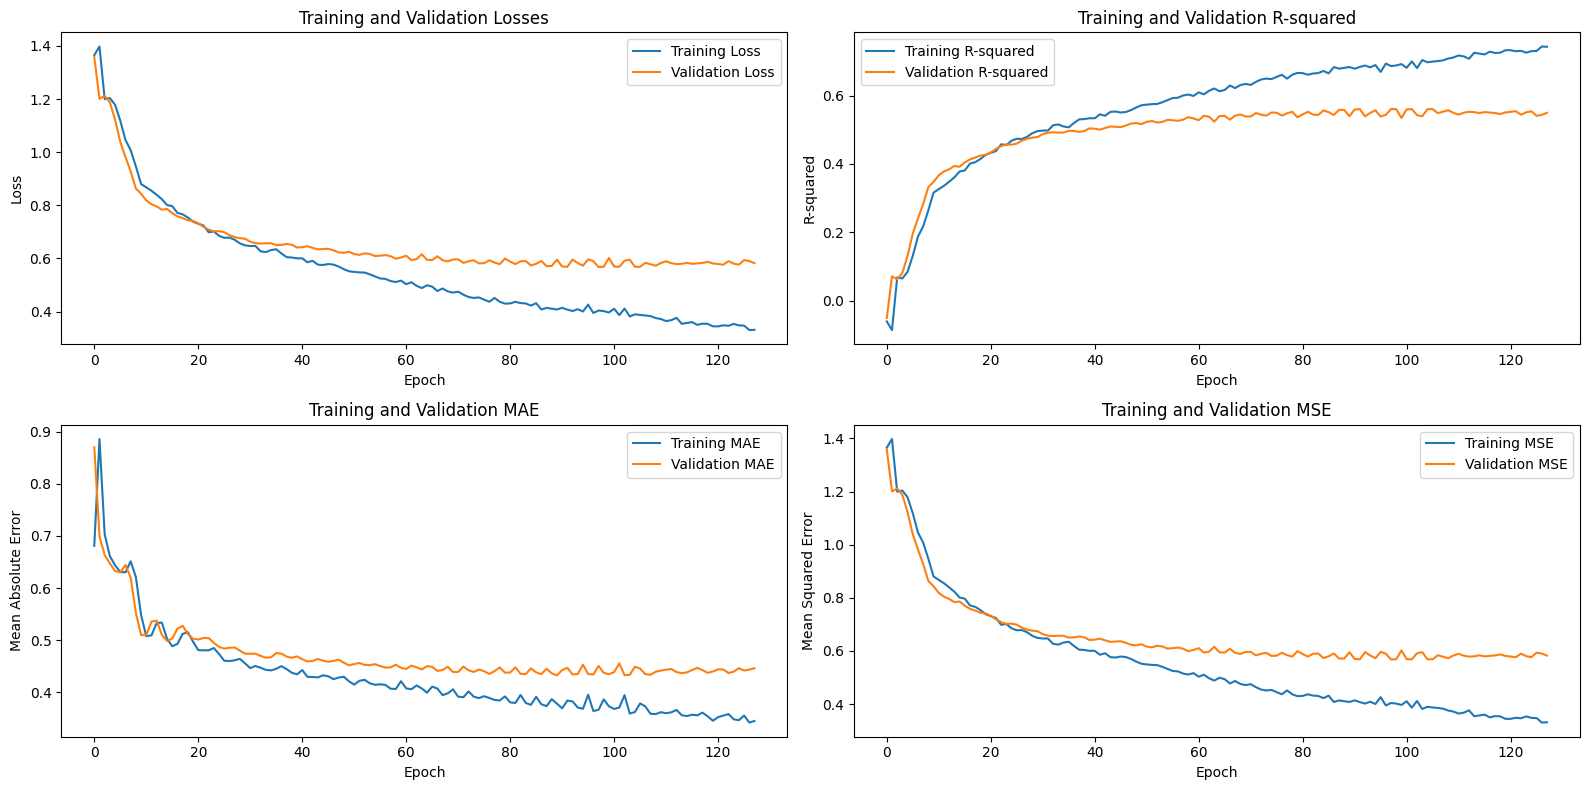

Test R-squared: 0.3989027577896659, Test MAE: 53.35498046875, Test MSE: 10588.619140625, Avg Test Residual: 4.623917102813721


In [ ]:
from sklearn.preprocessing import RobustScaler
import torch
from torch import optim
from torch_geometric.nn import SAGEConv
import joblib
import os
import optuna
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

# Specify the path to your Google Drive
drive_path = '/content/drive/My Drive/THESIS/'
os.makedirs(drive_path, exist_ok=True)
model_path = os.path.join(drive_path, 'pegnn_model_LONDON.pth')
study_path = os.path.join(drive_path, 'optuna_study_pegnn_LONDON.pkl')
input_size_path = os.path.join(drive_path, 'input_feature_size_LONDON.pkl')

# Function to save and load the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model_class, path, in_channels, hidden_channels):
    model = model_class(in_channels, hidden_channels)
    model.load_state_dict(torch.load(path))
    return model

# Function to save and load input feature size
def save_input_feature_size(size, path):
    with open(path, 'wb') as f:
        joblib.dump(size, f)

def load_input_feature_size(path):
    with open(path, 'rb') as f:
        size = joblib.load(f)
    return size

# Create edges using k-nearest neighbors
def create_edges_knn(coordinates, k=15):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(coordinates)
    distances, indices = nbrs.kneighbors(coordinates)
    edge_index = []
    for i, neighbors in enumerate(indices):
        for neighbor in neighbors:
            if i != neighbor:
                edge_index.append([i, neighbor])
                edge_index.append([neighbor, i])  # add both directions
    edge_index = np.array(edge_index).T
    return torch.tensor(edge_index, dtype=torch.long)

# Learnable Positional Embeddings
class PositionalEncoding(torch.nn.Module):
    def __init__(self, num_positions, d_model):
        super(PositionalEncoding, self).__init__()
        self.position_embeddings = torch.nn.Parameter(torch.zeros(num_positions, d_model))

    def forward(self, positions):
        return self.position_embeddings[positions]

# PEGNN model definition with a single fully connected layer
class PEGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, dropout_rate=0.5):
        super(PEGNN, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.out = torch.nn.Linear(hidden_channels, 1)  # Single fully connected layer with one output node

    def forward(self, x, edge_index):
        price_index = 1
        prices = x[:, price_index]

        # Mask out the node's own price during aggregation
        x_masked = x.clone()
        x_masked[:, price_index] = 0

        # Pass through the first convolutional layer with dropout
        x = self.conv1(x_masked, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Pass through the second convolutional layer
        x = self.conv2(x, edge_index)
        x = self.relu(x)
        x = self.dropout(x)

        # Directly pass to the final output layer
        x = self.out(x)

        return x

d_model = 128

# Optuna objective function
def objective(trial):
    hidden_channels = trial.suggest_int('hidden_channels', 32, 128)
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    k = trial.suggest_int('k', 1, 150)  # Hyperparameter for k-nearest neighbors
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    edge_index_train = create_edges_knn(train_coords_pegnn, k)
    edge_index_val = create_edges_knn(val_coords_pegnn, k)
    edge_index_test = create_edges_knn(test_coords_pegnn, k)

    positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
    pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
    pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
    pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

    x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
    x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
    x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

    model = PEGNN(in_channels=x_train.shape[1], hidden_channels=hidden_channels, dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization with weight_decay
    loss_fn = torch.nn.MSELoss()

    model.train()
    for epoch in tqdm(range(50), desc="Training PEGNN"):
        optimizer.zero_grad()
        out_train = model(x_train, edge_index_train)
        loss = loss_fn(out_train, y_train)
        loss.backward(retain_graph=True)
        optimizer.step()

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)

    return val_loss.item()

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

# Save the study
with open(study_path, 'wb') as f:
    joblib.dump(study, f)

best_params = study.best_params
print("Best parameters: ", best_params)

# Final training with best parameters
edge_index_train = create_edges_knn(train_coords_pegnn, best_params['k'])
edge_index_val = create_edges_knn(val_coords_pegnn, best_params['k'])
edge_index_test = create_edges_knn(test_coords_pegnn, best_params['k'])

positional_encoding = PositionalEncoding(num_positions=train_coords_pegnn.shape[0], d_model=d_model)
pos_enc_train = positional_encoding(torch.arange(train_coords_pegnn.shape[0]))
pos_enc_val = positional_encoding(torch.arange(val_coords_pegnn.shape[0]))
pos_enc_test = positional_encoding(torch.arange(test_coords_pegnn.shape[0]))

x_train = torch.cat([torch.tensor(train_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_train], dim=1)
x_val = torch.cat([torch.tensor(val_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_val], dim=1)
x_test = torch.cat([torch.tensor(test_features_pegnn.to_numpy(), dtype=torch.float), pos_enc_test], dim=1)

# Save input feature size
input_feature_size = x_train.shape[1]
save_input_feature_size(input_feature_size, input_size_path)

model = PEGNN(in_channels=input_feature_size, hidden_channels=best_params['hidden_channels'], dropout_rate=best_params['dropout_rate'])
optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)  # L2 regularization with weight_decay
loss_fn = torch.nn.MSELoss()

train_losses = []
val_losses = []
train_r2_scores = []
val_r2_scores = []
train_mae_scores = []
val_mae_scores = []
train_mse_scores = []
val_mse_scores = []

# Early stopping parameters
patience = 30
best_val_loss = float('inf')
patience_counter = 0

model.train()
for epoch in tqdm(range(500), desc="Final training"):
    optimizer.zero_grad()
    out_train = model(x_train, edge_index_train)
    loss = loss_fn(out_train, y_train)
    loss.backward(retain_graph=True)
    optimizer.step()
    train_losses.append(loss.item())

    y_train_np = y_train.detach().numpy()
    out_train_np = out_train.detach().numpy()
    train_r2 = r2_score(y_train_np, out_train_np)
    train_mae = mean_absolute_error(y_train_np, out_train_np)
    train_mse = mean_squared_error(y_train_np, out_train_np)
    train_r2_scores.append(train_r2)
    train_mae_scores.append(train_mae)
    train_mse_scores.append(train_mse)

    print(f'Epoch {epoch + 1}, Training Loss: {loss.item()}, Training R-squared: {train_r2}, Training MAE: {train_mae}, Training MSE: {train_mse}')

    model.eval()
    with torch.no_grad():
        out_val = model(x_val, edge_index_val)
        val_loss = loss_fn(out_val, y_val)
        val_losses.append(val_loss.item())

        y_val_np = y_val.detach().numpy()
        out_val_np = out_val.detach().numpy()
        val_r2 = r2_score(y_val_np, out_val_np)
        val_mae = mean_absolute_error(y_val_np, out_val_np)
        val_mse = mean_squared_error(y_val_np, out_val_np)
        val_r2_scores.append(val_r2)
        val_mae_scores.append(val_mae)
        val_mse_scores.append(val_mse)

    print(f'Epoch {epoch + 1}, Validation Loss: {val_loss.item()}, Validation R-squared: {val_r2}, Validation MAE: {val_mae}, Validation MSE: {val_mse}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        save_model(model, model_path)
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break

    model.train()

# Plotting
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')

plt.subplot(2, 2, 2)
plt.plot(train_r2_scores, label='Training R-squared')
plt.plot(val_r2_scores, label='Validation R-squared')
plt.xlabel('Epoch')
plt.ylabel('R-squared')
plt.legend()
plt.title('Training and Validation R-squared')

plt.subplot(2, 2, 3)
plt.plot(train_mae_scores, label='Training MAE')
plt.plot(val_mae_scores, label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Training and Validation MAE')

plt.subplot(2, 2, 4)
plt.plot(train_mse_scores, label='Training MSE')
plt.plot(val_mse_scores, label='Validation MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation MSE')

plt.tight_layout()
plt.show()

# Rescale predictions and targets for final evaluation
model.eval()
with torch.no_grad():
    out_train = model(x_train, edge_index_train)
    out_val = model(x_val, edge_index_val)
    out_test = model(x_test, edge_index_test)

# Inverse transform the predictions and actual values
out_train_rescaled = scaler.inverse_transform(out_train.numpy())
y_train_rescaled = scaler.inverse_transform(y_train.numpy())

out_val_rescaled = scaler.inverse_transform(out_val.numpy())
y_val_rescaled = scaler.inverse_transform(y_val.numpy())

out_test_rescaled = scaler.inverse_transform(out_test.numpy())
y_test_rescaled = scaler.inverse_transform(y_test.numpy())

# Compute metrics on the original scale
train_r2 = r2_score(y_train_rescaled, out_train_rescaled)
train_mae = mean_absolute_error(y_train_rescaled, out_train_rescaled)
train_mse = mean_squared_error(y_train_rescaled, out_train_rescaled)

val_r2 = r2_score(y_val_rescaled, out_val_rescaled)
val_mae = mean_absolute_error(y_val_rescaled, out_val_rescaled)
val_mse = mean_squared_error(y_val_rescaled, out_val_rescaled)

test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)
test_residuals_avg = np.mean(y_test_rescaled - out_test_rescaled)
print(f'Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}, Avg Test Residual: {test_residuals_avg}')


extra reporting metrics


Test Loss: 0.7869068384170532, Test R-squared: 0.3989027577896659, Test MAE: 53.35498046875, Test MSE: 10588.619140625


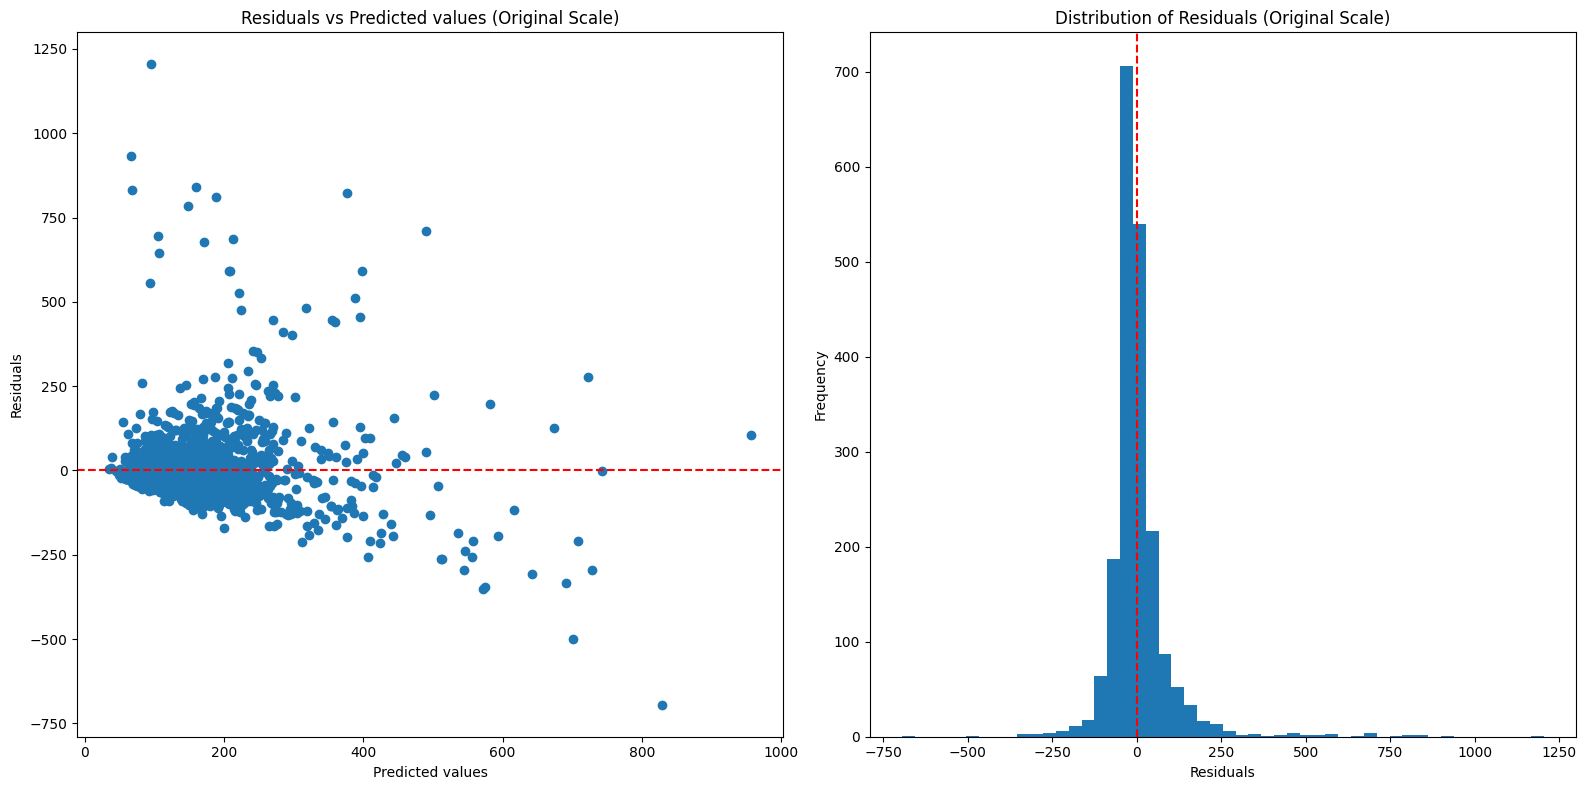

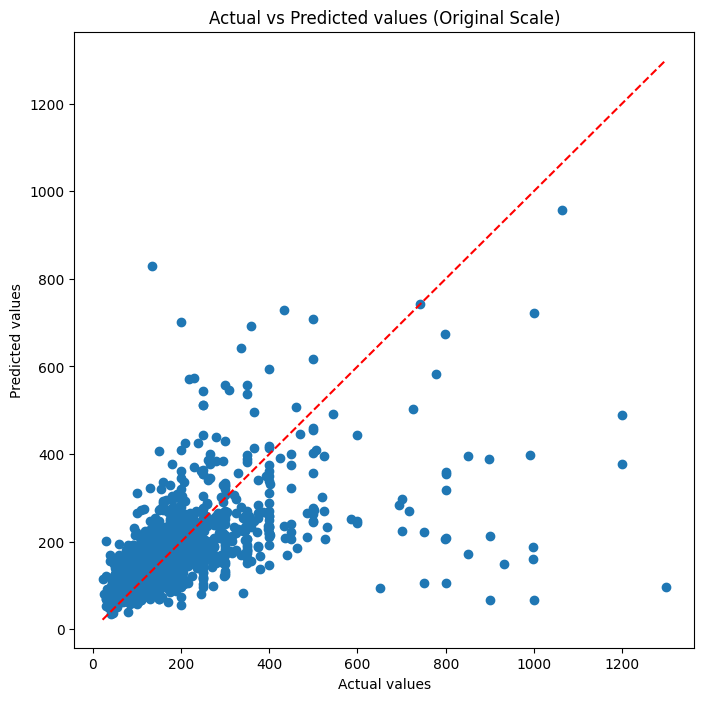

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    out_test = model(x_test, edge_index_test)
    test_loss = loss_fn(out_test, y_test)
    y_test_np = y_test.detach().numpy()
    out_test_np = out_test.detach().numpy()

# Inverse transform the predictions and actual values
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)

# Calculate evaluation metrics on the original scale
test_r2 = r2_score(y_test_rescaled, out_test_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, out_test_rescaled)
test_mse = mean_squared_error(y_test_rescaled, out_test_rescaled)

print(f'Test Loss: {test_loss.item()}, Test R-squared: {test_r2}, Test MAE: {test_mae}, Test MSE: {test_mse}')

# Calculate residuals in the original scale
residuals_rescaled = y_test_rescaled - out_test_rescaled

# Plotting residuals
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.scatter(out_test_rescaled, residuals_rescaled)
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted values (Original Scale)')
plt.axhline(0, color='red', linestyle='--')

plt.subplot(1, 2, 2)
plt.hist(residuals_rescaled, bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Original Scale)')
plt.axvline(0, color='red', linestyle='--')

plt.tight_layout()
plt.show()

# Plotting predicted vs actual values
plt.figure(figsize=(8, 8))
plt.scatter(y_test_rescaled, out_test_rescaled)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs Predicted values (Original Scale)')
plt.plot([min(y_test_rescaled), max(y_test_rescaled)], [min(y_test_rescaled), max(y_test_rescaled)], color='red', linestyle='--')
plt.show()


Text(0.5, 1.0, 'Heatmap of Predicted Prices')

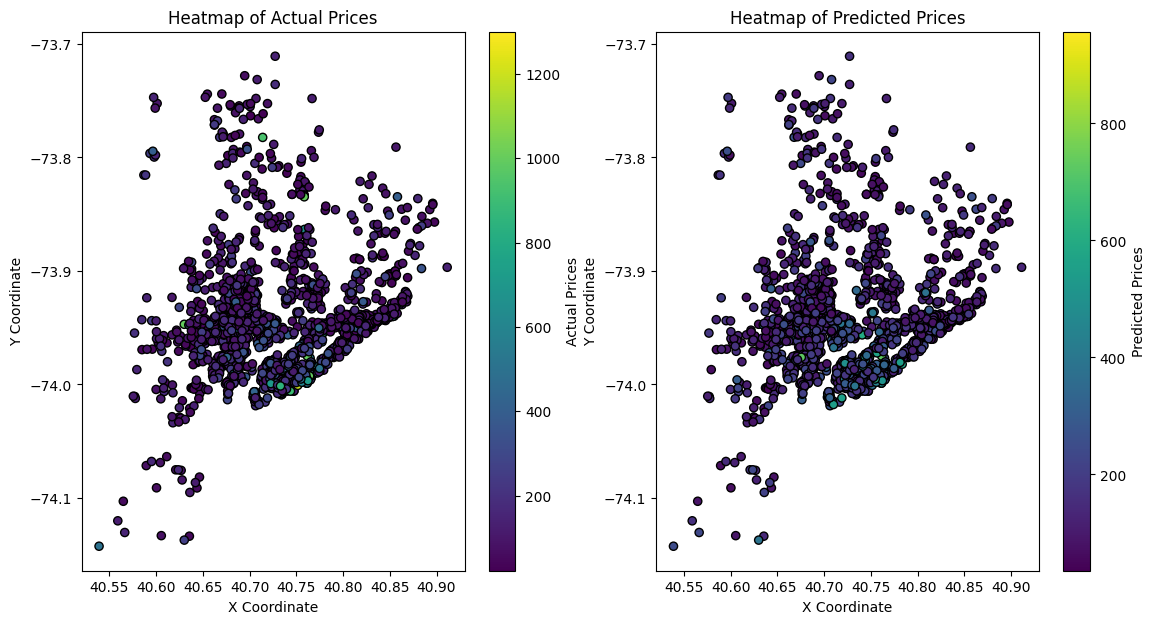

In [ ]:
import seaborn as sns

# Assuming 'coords_np' contains the coordinates and 'scaler' is used for inverse transformation
coords_np = np.array(test_coords_pegnn)

# Rescale the actual and predicted prices to original scale
y_test_rescaled = scaler.inverse_transform(y_test_np)
out_test_rescaled = scaler.inverse_transform(out_test_np)
residuals_rescaled = y_test_rescaled - out_test_rescaled

plt.figure(figsize=(21, 7))

# Heatmap of Actual Prices
plt.subplot(1, 3, 1)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=y_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Actual Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Actual Prices')

# Heatmap of Predicted Prices
plt.subplot(1, 3, 2)
plt.scatter(coords_np[:, 0], coords_np[:, 1], c=out_test_rescaled.flatten(), cmap='viridis', s=35, edgecolor='k')
plt.colorbar(label='Predicted Prices')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Predicted Prices')


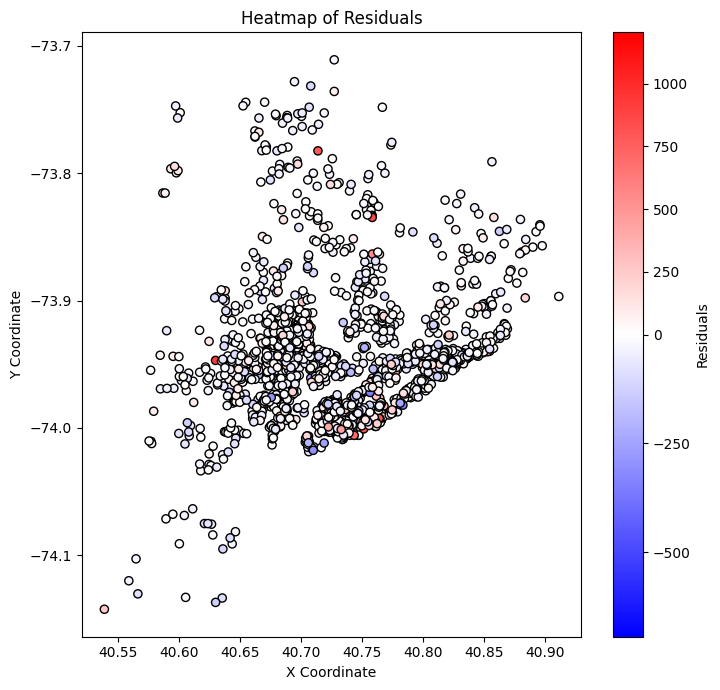

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm



# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(coords_np[:, 0], coords_np[:, 1], c=residuals_rescaled.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals')

plt.tight_layout()
plt.show()


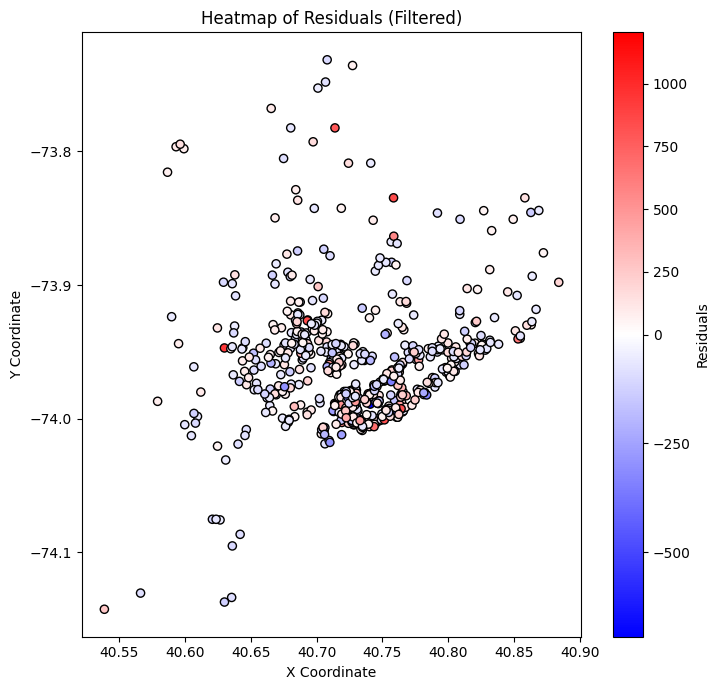

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming residuals_rescaled and coords_np are already defined

# Define a custom colormap with 0 as white
cmap = LinearSegmentedColormap.from_list('custom_coolwarm',
                                         [(0, 'blue'),
                                          (0.5, 'white'),
                                          (1, 'red')], N=256)

# Normalize the data so that 0 maps to white
norm = TwoSlopeNorm(vmin=residuals_rescaled.min(), vcenter=0, vmax=residuals_rescaled.max())

# Filter out residuals between -50 and 50
mask = (residuals_rescaled < -50) | (residuals_rescaled > 50)
filtered_coords = coords_np[mask.flatten()]
filtered_residuals = residuals_rescaled[mask]

# Create the plot
plt.figure(figsize=(21, 7))

# Heatmap of Residuals
plt.subplot(1, 3, 3)
sc = plt.scatter(filtered_coords[:, 0], filtered_coords[:, 1], c=filtered_residuals.flatten(), cmap=cmap, norm=norm, s=35, edgecolor='k')
plt.colorbar(sc, label='Residuals')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Heatmap of Residuals (Filtered)')

plt.tight_layout()
plt.show()


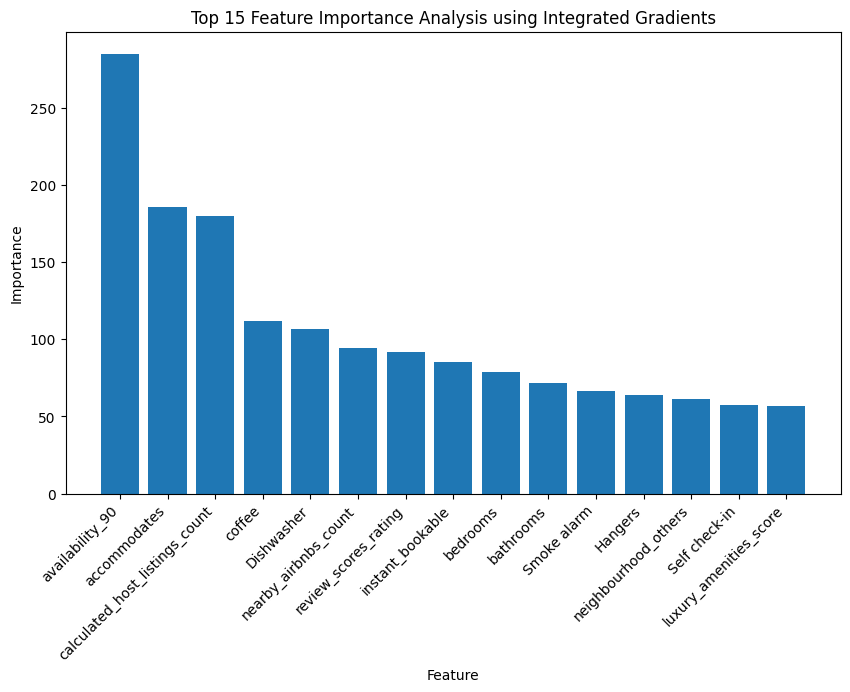

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Assuming model, x_test, edge_index_test, y_test, and feature_names are already defined

inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()


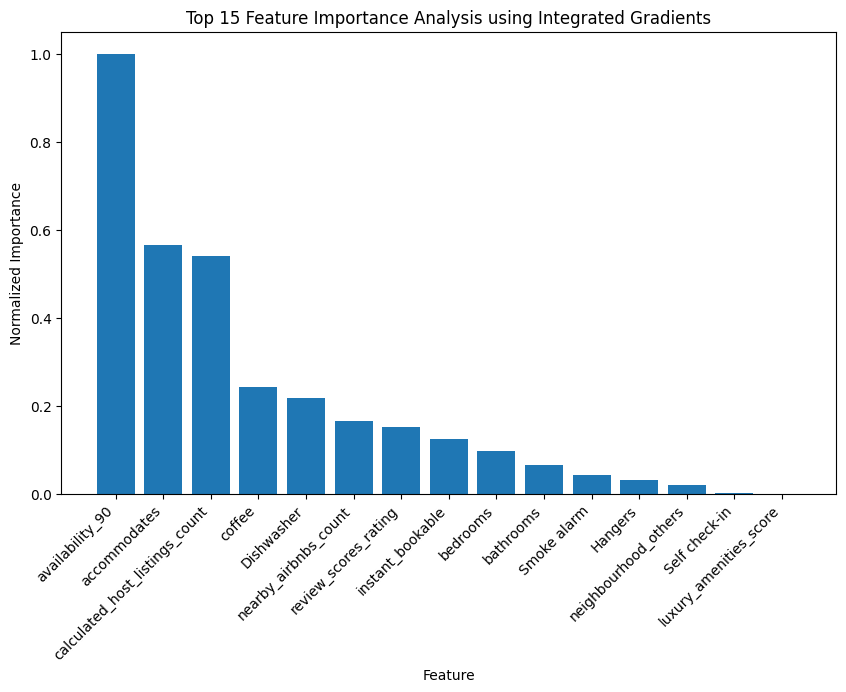

Top 15 Feature Importances (Normalized):
availability_90: 1.0000
accommodates: 0.5641
calculated_host_listings_count: 0.5402
coffee: 0.2421
Dishwasher: 0.2179
nearby_airbnbs_count: 0.1659
review_scores_rating: 0.1522
instant_bookable: 0.1245
bedrooms: 0.0963
bathrooms: 0.0656
Smoke alarm: 0.0418
Hangers: 0.0304
neighbourhood_others: 0.0200
Self check-in: 0.0024
luxury_amenities_score: 0.0000


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable

# Assuming train_features_pegnn, model, x_test, edge_index_test, and y_test are already defined

feature_names = train_features_pegnn.columns.tolist()

def integrated_gradients(model, inputs, edge_index, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads = []

    for input_ in scaled_inputs:
        input_ = Variable(input_, requires_grad=True)
        output = model(input_, edge_index)
        target = output[:, target_class].sum()
        target.backward(retain_graph=True)
        grads.append(input_.grad.cpu().detach().numpy())

    grads = np.array(grads)
    avg_grads = np.mean(grads[:-1], axis=0)
    integrated_grads = (inputs.cpu().detach().numpy() - baseline.cpu().detach().numpy()) * avg_grads

    return integrated_grads

# Get the inputs and baseline for the entire graph
inputs = x_test  # Use all node features in the graph
baseline = torch.zeros_like(inputs)

# Compute Integrated Gradients for each node in the graph
target_class = 0  # Assuming the target class is the first output
integrated_grads = integrated_gradients(model, inputs, edge_index_test, target_class, baseline)

# Summing up the attributions for all nodes to get overall feature importances
overall_feature_importances = np.sum(integrated_grads, axis=0)

# Get the top 15 features
top_features_idx = np.argsort(overall_feature_importances)[-15:][::-1]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = overall_feature_importances[top_features_idx]

# Normalize the top 15 feature importances to the range [0, 1]
min_importance = np.min(top_importances)
max_importance = np.max(top_importances)
normalized_importances = (top_importances - min_importance) / (max_importance - min_importance)

# Visualize top 15 feature importances
plt.figure(figsize=(10, 6))
plt.bar(top_features, normalized_importances)
plt.xlabel('Feature')
plt.ylabel('Normalized Importance')
plt.title('Top 15 Feature Importance Analysis using Integrated Gradients')
plt.xticks(rotation=45, ha='right')
plt.show()

# Create a DataFrame for the top 15 features and their normalized importances
feature_importances_df = pd.DataFrame({
    'Feature': top_features,
    'Normalized Importance': normalized_importances
})

# Save the DataFrame to a CSV file
# Specify the path in Google Drive where you want to save the files
path = '/content/drive/My Drive/THESIS/'

# Save the processed data to CSV files
feature_importances_df.to_csv(path + 'feature_importances_with_lstm_london.csv', index=False)
# Display the list of top 15 features with their normalized importances
print("Top 15 Feature Importances (Normalized):")
for feature, importance in zip(top_features, normalized_importances):
    print(f"{feature}: {importance:.4f}")